In [1]:
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

dataset = load_dataset("imdb")

Reusing dataset imdb (C:\Users\segod\.cache\huggingface\datasets\imdb\plain_text\1.0.0\e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
x_train = dataset["train"][:]["text"]
y_train = dataset["train"][:]["label"]

x_test = dataset["test"][:]["text"]
y_test = dataset["test"][:]["label"]

-----------------------------------

## Logistic Regression

In [3]:
import pandas as pd
import numpy as np

Use the following features to start with.

    1 if "no" appear in the doc, 0 otherwise
    The count of first and second pronouns in the document
    1 if "!" is in the document, 0 otherwise
    log(word count in the document)
    Number of words in the document which are in the positive lexicon
    Number of words in the document which are in the negative lexicon


In [4]:
vs = pd.read_csv("vader_lexicon.txt", sep="\t", names=["TOKEN", "MEAN-SENTIMENT-RATING", "STANDARD DEVIATION", "RAW-HUMAN-SENTIMENT-RATINGS"])
vs.head()

,TOKEN,MEAN-SENTIMENT-RATING,STANDARD DEVIATION,RAW-HUMAN-SENTIMENT-RATINGS
0,$:,-1.5,0.80623,"[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]"
1,%),-0.4,1.01980,"[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]"
2,%-),-1.5,1.43178,"[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]"
3,&-:,-0.4,1.42829,"[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]"
4,&:,-0.7,0.64031,"[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]"


In [5]:
x_df = pd.DataFrame(x_train)

In [6]:
vs_dict = dict(zip(vs.TOKEN, vs["MEAN-SENTIMENT-RATING"]))

In [7]:
from multiprocessing import Pool

nbr_features = 6
def get_features(string):
    threshold = 2
    X0, X1, X2, X3, X4, X5 = 0,0,0,0,0,0
    str_split = string.split()

    if "no" in str_split:
        X0 = 1
    
    
    for word in str_split:
        if word in vs_dict:
            if vs_dict[word] < -threshold:
                X5 += 1
            elif vs_dict[word] > threshold:
                X4 += 1
        if word == "you" or word == "I":
            X1 += 1
            
    X2 = (string.find("!") != -1)
    X3 = np.log(len(str_split))
    return X0, X1, X2, X3, X4, X5

def logistic_transformation(x):
    res = np.zeros((len(x), nbr_features))
    for i, elt in enumerate(x):
        res[i][0], res[i][1],res[i][2],res[i][3],res[i][4], res[i][5] = get_features(elt)
    return res

In [8]:
%%time
lr_x_train = logistic_transformation(x_train)

Wall time: 789 ms


In [9]:
%%time
lr_x_test = logistic_transformation(x_test)

Wall time: 775 ms


In [10]:
print(lr_x_train)

[[ 0.          4.          1.          4.94164242  0.          1.        ]
 [ 0.          5.          0.          6.0591232   7.          3.        ]
 [ 0.          2.          0.          4.99043259  2.          2.        ]
 ...
 [ 0.         10.          1.          5.66642669  3.          1.        ]
 [ 0.          4.          0.          5.44673737  3.          2.        ]
 [ 0.          3.          0.          4.93447393  0.          2.        ]]


In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
lr_x_train = np.array(lr_x_train)

In [13]:
lr = LogisticRegression(random_state=42).fit(lr_x_train, y_train)

In [14]:
y_pred = lr.predict(lr_x_test)
accuracy_score(y_test, y_pred)

0.6978

Threshold | Acc
----------|-----
1 | 0.69668
1.8 | 0.69488
2 | 0.6978
2.2 | 0.69508
3 | 0.64512
1.2 / -2 | 0.679

In [15]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.68973985, 0.70657532]),
 array([0.71904, 0.67656]),
 array([0.70408523, 0.69124198]),
 array([12500, 12500], dtype=int64))

In [16]:
from sklearn.metrics import classification_report
import seaborn as sns

<AxesSubplot:>

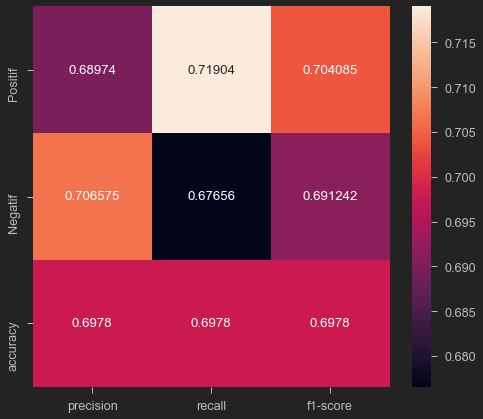

In [19]:
clf_report = classification_report(y_test,
                                   y_pred,
                                   target_names=["Positif", "Negatif"],
                                   output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-2].T, annot=True, fmt='g')